## Image classifier for the SVHN dataset


In [1]:
import tensorflow as tf
from scipy.io import loadmat

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading the dataset

train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

In [3]:
# Inspecting the dataset

print(train.keys())
print(train['X'].shape)
print(np.unique(train['y']))
print(np.unique(test['y']))

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
(32, 32, 3, 73257)
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]


In [4]:
#Divided images values by 255 so they fall between 0 and 1 
train_labels = train['y']
train_images = train['X']/255
test_labels = test['y']
test_images = test['X']/255

In [5]:
#Labels that are the number 10 correspond to training images of a zero. These labels should be converted to 0, otherwise 
#the output layer softmax in the model won't work 

train_labels[train_labels[:]==10] = 0
test_labels[test_labels[:]==10] = 0

In [6]:
#Suffle images 
def shuffle(images, labels, m):
    random_index = list(np.random.permutation(m))
    random_im = images[:,:,:,random_index]
    
    random_labels = labels[random_index]
    
    return random_im, random_labels
    
train_images, train_labels = shuffle(train_images, train_labels, train_images.shape[3])    

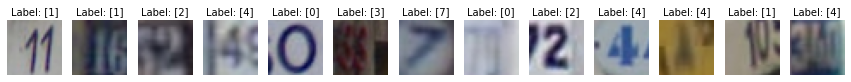

In [7]:
# Select random training images to display

train_examples_num = train_images.shape[3] #number of train examples
random_ind = np.random.choice(train_examples_num, 13) #generate 13 numbers randomly from number of train examples 
random_train_im = train_images[..., random_ind] #take 13 random images

random_train_lab = train_labels[random_ind] #take corresponding labels

fig, axes = plt.subplots(nrows=1, ncols=13, figsize=(15, 15)) #generate subplot with 1 row and 13 columns
  
for (i, ax) in enumerate(axes.flat): # flatten the generated axes
    img = random_train_im[:,:,:,i] #take random image i
    ax.set_axis_off() 
    ax.imshow(np.squeeze(img))  
    ax.set_title('Label: ' +str(random_train_lab[i]), fontsize=10)
        

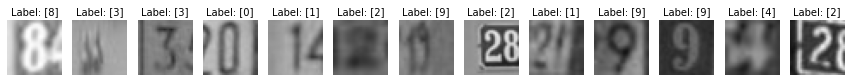

In [8]:
#Convert images to gray

def convert_gray(data, labels, print_it):
    num_toprint=13
    m = data.shape[3] #number of examples
    data = np.average(data, axis = 2)
    
    if print_it:
        ones = np.ones((32, 32, 3, 1))
        
        random_ind = np.random.choice(m, num_toprint) #random index to print some images 
        random_data_gr = data[..., random_ind] #take images to print
        random_lab = labels[random_ind] #take labels
       
        print_data = random_data_gr[:,:,np.newaxis,:] * ones #add dummy index to be able to print
        print_labels = random_lab
        
        fig, axes = plt.subplots(nrows=1, ncols=num_toprint, figsize=(15, 15))
        for (i, ax) in enumerate(axes.flat):
            
            img = print_data[:,:,:,i]
            ax.set_axis_off()
            ax.imshow(np.squeeze(img))  
            ax.set_title('Label: ' +str(print_labels[i]), fontsize=10)
            
    return data.T  

train_images = convert_gray(train_images,train_labels,True)
test_images_gr = convert_gray(test_images, test_labels, False)

## MLP neural network classifier

In [9]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Softmax, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, CSVLogger
import pandas as pd


In [10]:

def get_model(input_shape):
    
    model = Sequential([
            Flatten(input_shape=input_shape),
            Dense(128, activation='tanh', kernel_initializer='he_normal', bias_initializer='ones', 
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            Dense(64, activation='tanh',kernel_initializer='he_normal', bias_initializer='ones',
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            Dense(64, activation='tanh',kernel_initializer='he_normal', bias_initializer='ones',
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            
            Dense(10, activation='softmax')
    ])
    return model

In [11]:
print(train_images[0,:,:].shape)

(32, 32)


In [12]:
model = get_model(train_images[0,:,:].shape)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 144,266
Trainable params: 144,266
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
print(train_images[0,:,:].shape)
print(train_labels.shape)
print(train_images.shape)

checkpoint = ModelCheckpoint('Model_1', save_weights_only=False, save_best_only=True)

history = model.fit(train_images,train_labels, epochs=30, batch_size=10, validation_split=.15, 
                    callbacks=[checkpoint, tf.keras.callbacks.CSVLogger("Model1_results.csv")])



(32, 32)
(73257, 1)
(73257, 32, 32)
Epoch 1/30
6227/6227 [==============================] - 10s 2ms/step - loss: 2.4780 - accuracy: 0.2381 - val_loss: 2.1732 - val_accuracy: 0.3587
INFO:tensorflow:Assets written to: Model_1/assets
Epoch 2/30
6227/6227 [==============================] - 9s 1ms/step - loss: 1.8800 - accuracy: 0.4658 - val_loss: 1.7399 - val_accuracy: 0.5159
INFO:tensorflow:Assets written to: Model_1/assets
Epoch 3/30
6227/6227 [==============================] - 9s 2ms/step - loss: 1.5959 - accuracy: 0.5755 - val_loss: 1.5313 - val_accuracy: 0.6016
INFO:tensorflow:Assets written to: Model_1/assets
Epoch 4/30
6227/6227 [==============================] - 9s 1ms/step - loss: 1.4627 - accuracy: 0.6268 - val_loss: 1.4372 - val_accuracy: 0.6366
INFO:tensorflow:Assets written to: Model_1/assets
Epoch 5/30
6227/6227 [==============================] - 9s 1ms/step - loss: 1.3783 - accuracy: 0.6539 - val_loss: 1.3547 - val_accuracy: 0.6628
INFO:tensorflow:Assets written to: Model_1/

In [14]:
pd.read_csv("Model1_results.csv", index_col = 'epoch')

,accuracy,loss,val_accuracy,val_loss
epoch,,,,
0,0.238084,2.478049,0.358722,2.173184
1,0.465777,1.879994,0.515880,1.739900
2,0.575512,1.595883,0.601602,1.531260
3,0.626775,1.462720,0.636637,1.437193
4,0.653899,1.378280,0.662754,1.354712
5,0.675194,1.313904,0.666758,1.329382
6,0.686002,1.268955,0.682683,1.270512
7,0.699525,1.229328,0.702976,1.213277
8,0.708887,1.196150,0.702248,1.202934


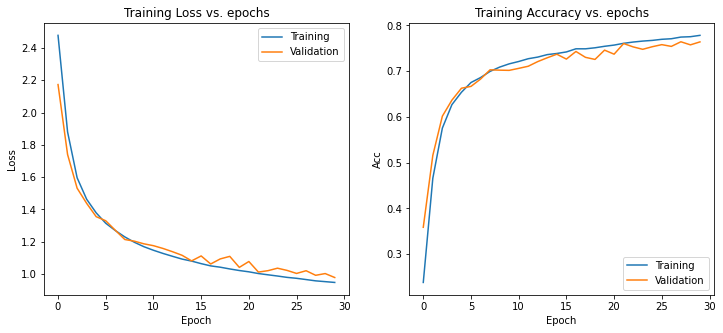

In [15]:
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs. epochs')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')



In [16]:
#Loss and accuracy on test set

test = model.evaluate(test_images_gr, test_labels, batch_size = 10, return_dict=True, verbose=1)
print("Loss",test['loss'])
print("Accuracy", test['accuracy'])

2604/2604 [==============================] - 2s 829us/step - loss: 1.0516 - accuracy: 0.7488
Loss 1.051615834236145
Accuracy 0.7487707734107971


## CNN neural network classifier

In [17]:
def CNN_model():
    model = Sequential([
                Conv2D(16,(3,3), padding='SAME', activation='relu', input_shape=(32,32,1)),
                BatchNormalization(),
                Dropout(.2),
                MaxPooling2D((3,3)),
                Conv2D(16,(3,3), padding='SAME', activation='relu'),
                BatchNormalization(),
                MaxPooling2D((3,3)),
                Flatten(),
                Dense(64, activation='relu',kernel_initializer='he_normal', bias_initializer='ones',
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)),   
                Dense(10, activation='softmax')

    ])
    return model

In [18]:
print(train_images[:,:,:].shape)
model2 = CNN_model()     

(73257, 32, 32)


In [19]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 16)         

In [20]:
model2.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
print(train_images[0,:,:].shape)
print(train_labels.shape)
print(train_images.shape)

checkpoint = ModelCheckpoint('Model_2', save_weights_only=False, save_best_only=True)

history2 = model2.fit(train_images[...,np.newaxis],train_labels, epochs=30, batch_size=10, validation_split=.15, 
                    callbacks=[checkpoint, tf.keras.callbacks.CSVLogger("Model2_results.csv")])

(32, 32)
(73257, 1)
(73257, 32, 32)
Epoch 1/30
6227/6227 [==============================] - 50s 8ms/step - loss: 1.9614 - accuracy: 0.3953 - val_loss: 1.3333 - val_accuracy: 0.6132
INFO:tensorflow:Assets written to: Model_2/assets
Epoch 2/30
6227/6227 [==============================] - 49s 8ms/step - loss: 1.0951 - accuracy: 0.6896 - val_loss: 1.0029 - val_accuracy: 0.7195
INFO:tensorflow:Assets written to: Model_2/assets
Epoch 3/30
6227/6227 [==============================] - 50s 8ms/step - loss: 0.8861 - accuracy: 0.7607 - val_loss: 0.8737 - val_accuracy: 0.7675
INFO:tensorflow:Assets written to: Model_2/assets
Epoch 4/30
6227/6227 [==============================] - 49s 8ms/step - loss: 0.7951 - accuracy: 0.7877 - val_loss: 0.8059 - val_accuracy: 0.7904
INFO:tensorflow:Assets written to: Model_2/assets
Epoch 5/30
6227/6227 [==============================] - 49s 8ms/step - loss: 0.7374 - accuracy: 0.8050 - val_loss: 0.7717 - val_accuracy: 0.7980
INFO:tensorflow:Assets written to: Mode

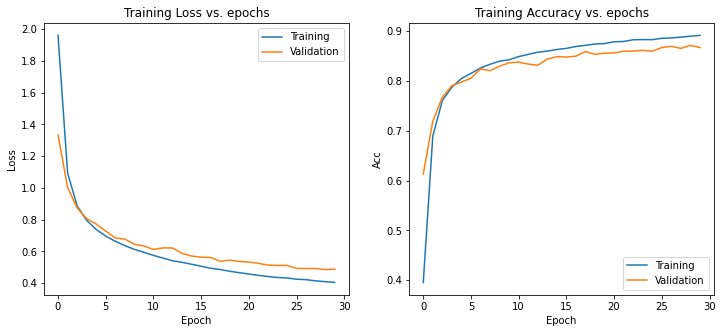

In [21]:
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Training Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Training Accuracy vs. epochs')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

In [22]:
#Loss and accuracy on test set

test = model2.evaluate(test_images_gr[...,np.newaxis], test_labels, batch_size = 10, return_dict=True, verbose=1)
print("Loss",test['loss'])
print("Accuracy", test['accuracy'])

2604/2604 [==============================] - 6s 2ms/step - loss: 0.5318 - accuracy: 0.8535
Loss 0.5318433046340942
Accuracy 0.8535264134407043


## Models predictions


In [23]:
#Loading best weights and models for each version  

MLP = load_model('Model_1')
CNN = load_model('Model_2')

In [24]:
#Randomly select 5 images and labels from the test set

random_ix = np.random.choice(test_images.shape[3], 5) #random index to print some images 
random_im = test_images[..., random_ix] #take images to print
random_labels = test_labels[random_ix] #take labels
random_images_gr = convert_gray(random_im, random_labels, False)


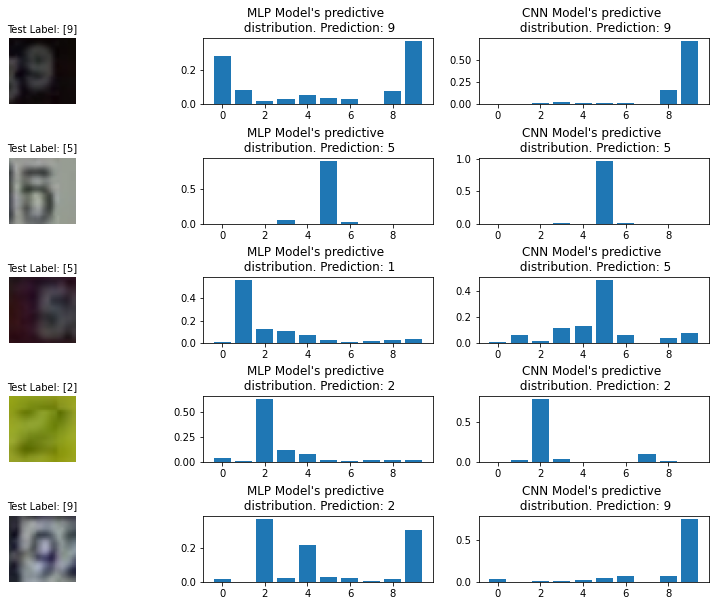

In [45]:
#Results

predictionsMLP = MLP.predict(random_images_gr)
predictionsCNN = CNN.predict(random_images_gr[...,np.newaxis])

fig, axes = plt.subplots(5,3, figsize=(14, 10))
fig.subplots_adjust(hspace=.8, wspace=0.2)
for (i, ax) in enumerate(axes):
    axes[i, 0].set_axis_off()
    axes[i, 0].imshow(np.squeeze(random_im[:,:,:,i]))
    axes[i, 0].set_title('Test Label: ' +str(random_labels[i]), fontsize=10)
    axes[i, 1].bar(np.arange(len(predictionsMLP[i])), predictionsMLP[i])
    axes[i, 1].set_title(f"MLP Model's predictive \n distribution. Prediction: {np.argmax(predictionsMLP[i])}")
    axes[i, 2].bar(np.arange(len(predictionsCNN[i])), predictionsCNN[i])
    axes[i, 2].set_title(f"CNN Model's predictive \n distribution. Prediction: {np.argmax(predictionsCNN[i])}")
